In [14]:
# Python Essentials 
import numpy as np
import pandas as pd
import pandas_datareader as web

# To import and format timeStamps
import datetime as dt
from datetime import date

# Our Cryptocurrency Live Data API
import fastquant as fq

# Data Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

# Hadoop Access Client
from snakebite.client import Client

# Deep Learning libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


In [15]:
crypto_currency = input('Enter the CryptoCurrency: ') 
against_currency = input('Enter the CryptoCurrency you want to trade ' + crypto_currency +' against: ')    

Enter the CryptoCurrency: ADA
Enter the CryptoCurrency you want to trade ADA against: BTC


In [16]:
client = Client('localhost', 9000)
for a in client.copyToLocal(['/hData/'+crypto_currency+'-'+against_currency+'.csv'], 'C:/Users/Neel/Desktop/Hadoop/'):
        print(a)

{'path': 'C:\\Users\\Neel\\Desktop\\Hadoop\\ADA-BTC.csv', 'result': True, 'error': '', 'source_path': '/hData/ADA-BTC.csv'}


In [17]:
data= pd.read_csv(crypto_currency+'-'+against_currency+".csv",index_col=0)

In [18]:
data

,open,high,low,close,volume
dt,,,,,
2020-01-02,0.000005,0.000005,0.000005,0.000005,25328513.0
2020-01-03,0.000005,0.000005,0.000005,0.000005,43527066.0
2020-01-04,0.000005,0.000005,0.000005,0.000005,25959654.0
2020-01-05,0.000005,0.000005,0.000005,0.000005,30087484.0
2020-01-06,0.000005,0.000005,0.000005,0.000005,72810857.0
...,...,...,...,...,...
2021-11-21,0.000032,0.000032,0.000031,0.000031,15599647.7
2021-11-22,0.000031,0.000032,0.000031,0.000032,25478109.4
2021-11-23,0.000032,0.000032,0.000030,0.000030,26461203.2


In [19]:
# Prepare Data
#print(data.head())

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

prediction_days = 60

x_train, y_train = [], []
 
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [20]:
# Create Neural Network

model = Sequential()

model.add(LSTM(units=20, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [21]:
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
10/10 [==============================] - 14s 118ms/step - loss: 0.1312
Epoch 2/10
10/10 [==============================] - 1s 121ms/step - loss: 0.0423 0s - loss: 0.042
Epoch 3/10
10/10 [==============================] - 1s 130ms/step - loss: 0.0257
Epoch 4/10
10/10 [==============================] - 1s 127ms/step - loss: 0.0186
Epoch 5/10
10/10 [==============================] - 2s 256ms/step - loss: 0.0117
Epoch 6/10
10/10 [==============================] - 1s 133ms/step - loss: 0.0120
Epoch 7/10
10/10 [==============================] - 2s 249ms/step - loss: 0.0098 0s - loss: 0.00
Epoch 8/10
10/10 [==============================] - 1s 147ms/step - loss: 0.0098
Epoch 9/10
10/10 [==============================] - 3s 281ms/step - loss: 0.0103
Epoch 10/10
10/10 [==============================] - 2s 150ms/step - loss: 0.0091


In [22]:
y = -20
test_start = '2021-01-01'
test_end = date.today()
test_end= test_end.strftime("%Y-%m-%d")

test_data = fq.get_crypto_data(crypto_currency+'/'+against_currency, test_start, test_end,time_resolution="1d")
actual_prices = test_data['close'].values[:y]
dates = test_data.index.values

total_dataset = pd.concat((data['close'], test_data['close']), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [23]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

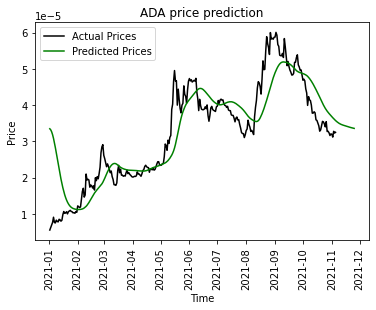

In [24]:
plt.plot(dates[:y], actual_prices, color='black', label='Actual Prices')
plt.plot(dates, prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.savefig(crypto_currency+'-'+against_currency+'.png')
plt.show()

In [25]:
import sklearn.metrics as sm
print("Mean absolute error =", sm.mean_absolute_error(actual_prices, prediction_prices[:y]))
print("Mean squared error =", sm.mean_squared_error(actual_prices, prediction_prices[:y])) 
print("Median absolute error =", sm.median_absolute_error(actual_prices, prediction_prices[:y])) 
print("Explain variance score =", sm.explained_variance_score(actual_prices, prediction_prices[:y])) 
print("R2 score =", sm.r2_score(actual_prices, prediction_prices[:y]))

Mean absolute error = 4.860357731445291e-06
Mean squared error = 4.79579979102968e-11
Median absolute error = 3.5878719530487436e-06
Explain variance score = 0.749724367029885
R2 score = 0.7491326137991862
